# Bottleneck Transformer

According to "Bottleneck Transformers for Visual Recognition", [arXiv:2101.11605 [cs.CV]](https://arxiv.org/abs/2101.11605)

Parts of code from https://gist.github.com/aravindsrinivas/56359b79f0ce4449bcb04ab4b56a57a2

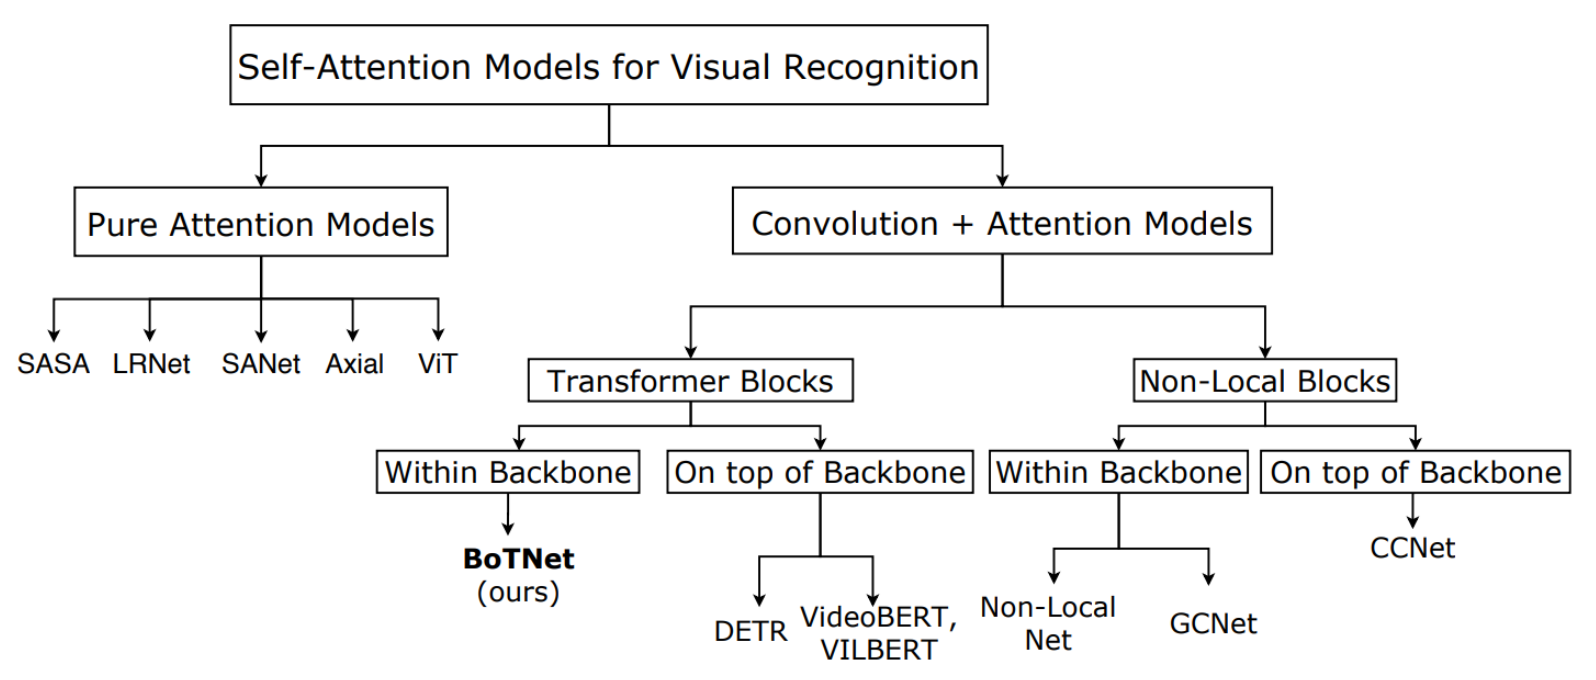

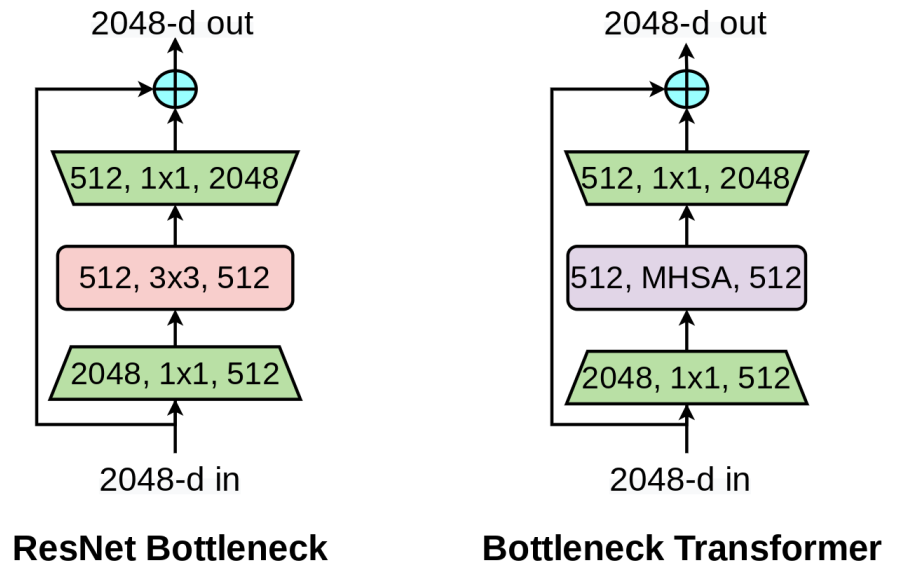

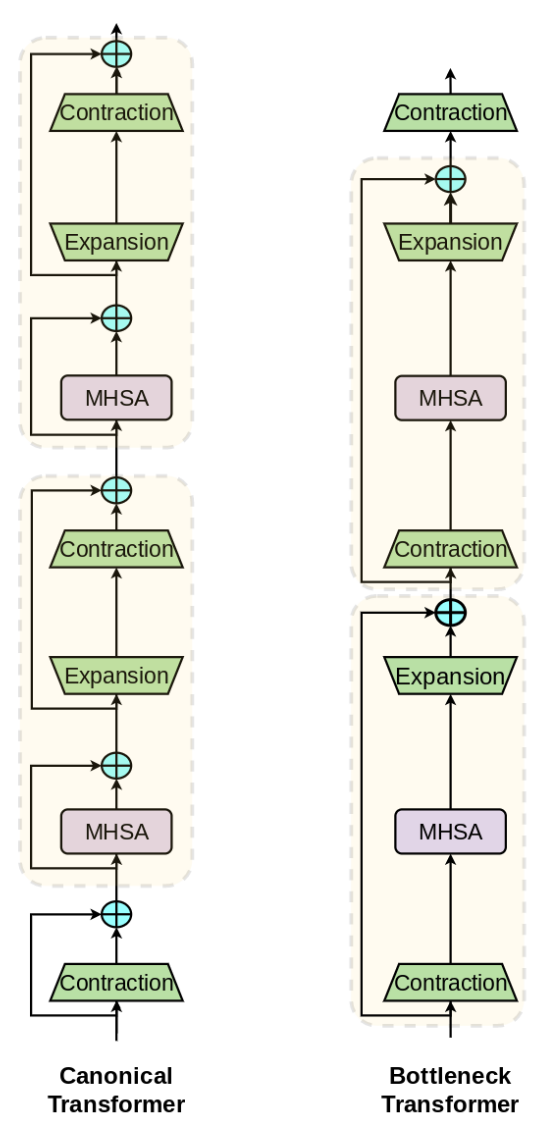

BoT50 warrants longer training in order to show significant improvement over R50.

BoTNet (self-attention) benefits more from extra augmentations such as multi-scale jitter compared to ResNet (pure convolutions).

Self-attention replacement is more efficient than stacking convolutions.

Replacing 3 spatial convolutions with `all2all` attention gives more improvement in the metrics compared to stacking 50 more layers of convolutions (R101), and is competitive with stacking 100 more layers (R152).

BoT50 does not provide significant gains over R50 on ImageNet though it does provide the benefit of reducing the parameters while maintaining comparable computation.

ResNets and SENets perform really well in the lower accuracy regime, outperforming both EfficientNets and BoTNets.

EfficientNets may be better in terms of M.Adds, but do not map as well as BoTNets, onto the latest hardware accelerators such as TPUs.

ResNets and SENets achieve strong performance in the improved EfficientNet training setting. They are strong enough that they can outperform all the EfficientNets.

Pure convolutional models such as ResNets and SENets are still the best performing models until an accuracy regime of 83% top-1 accuracy.

We recommend using absolute position encodings for image classification.

## Configuration

Imports

In [47]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [3]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 100

In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [6]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [8]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

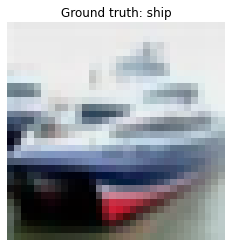

In [9]:
dataset_show_image(test_dset, 1)

## Model

### Self Attention for vision

Attention:
$$
O=V\mathrm{softmax}\left[\frac{1}{\sqrt{c}}(K^{\intercal}Q + P^{\intercal}Q)\right]\,.
$$
Here $P$ represents position encoding.
$V,K,P,Q\in\mathbb{R}^{c\times n}$, $c$ is the number of channels, $n$ is the number of elements.
Thus $K^{\intercal}Q,P^{\intercal}Q\in\mathbb{R}^{n\times n}$.

In [10]:
class RelativePosEnc(nn.Module):
    def forward(self, q):
        if not hasattr(self, 'pos_h'):
            c, h, w = q.shape[-3:]
            self.pos_h = nn.Parameter(torch.zeros(2 * h - 1, c, device=q.device))
            self.pos_w = nn.Parameter(torch.zeros(2 * w - 1, c, device=q.device))
        
        rel_h = self.pos_h @ q.movedim(4, 2)
        rel_w = self.pos_w @ q.movedim(3, 2)
                        
        rel_h = self.rel_to_abs(rel_h).movedim(2, 4)
        rel_w = self.rel_to_abs(rel_w).movedim(2, 3)
                
        pos_enc = rel_h[:, :, :, None] + rel_w[:, :, None, :]
        pos_enc = pos_enc.flatten(-2).flatten(2, 3)
        
        return pos_enc
    
    @staticmethod
    def rel_to_abs(x):
        """
        Converts relative indexing to absolute.
        Input shape: [..., 2 * length - 1, length]
        Output shape: [..., length, length]
        """
        shape = x.shape
        length = shape[-1]
        # reshape [..., 2*length-1, length] -> [..., 2*length-1, length+1] :
        x = F.pad(x, (0, 0, 0, 1))        # [..., 2*length, length]
        x = x.flatten(-2)                 # [..., 2*length**2]
        x = F.pad(x, (0, length-1))       # [..., 2*length**2+length-1]
        x = x.view(*shape[:-1], length+1) # [..., 2*length-1, length+1]
        # take the right elements
        x = x[..., length-1:, :length]
        return x

In [11]:
class AbsolutePosEnc(nn.Module):
    def forward(self, q):
        if not hasattr(self, 'pos_h'):
            c, h, w = q.shape[-3:]
            self.pos_h = nn.Parameter(torch.zeros(h, c, device=q.device))
            self.pos_w = nn.Parameter(torch.zeros(w, c, device=q.device))
        
        pos_enc = self.pos_h[:, None] + self.pos_w[None, :]
        pos_enc = pos_enc.flatten(0, 1) @ q.flatten(-2)
        return pos_enc

In [12]:
class SelfAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, q_channels, v_channels, heads, pos_enc, p_drop=0.):
        super().__init__()
        self.heads= heads
        self.q_channels = q_channels
        self.scale = q_channels**-0.5
        self.to_pos_enc = pos_enc()
        
        self.to_keys = nn.Conv2d(in_channels, q_channels * heads, 1)
        self.to_queries = nn.Conv2d(in_channels, q_channels * heads, 1)
        self.to_values = nn.Conv2d(in_channels, v_channels * heads, 1)
        self.unifyheads = nn.Conv2d(v_channels * heads, out_channels, 1)

        self.attn_drop = nn.Dropout(p_drop)
        self.resid_drop = nn.Dropout(p_drop)
    
    def forward(self, x):
        b, _, h, w = x.shape
        
        keys = self.to_keys(x).view(b, self.heads, self.q_channels, h * w)
        queries = self.to_queries(x).view(b, self.heads, self.q_channels, h, w)
        values = self.to_values(x).view(b, self.heads, -1, h * w)
        
        pos_enc = self.to_pos_enc(queries)
        queries = queries.flatten(-2)
        
        att = keys.transpose(-2, -1) @ queries + pos_enc
        att = F.softmax(att * self.scale, dim=-2)
        att = self.attn_drop(att)
        
        out = values @ att
        out = out.view(b, -1, h, w)
        out = self.unifyheads(out)
        out = self.resid_drop(out)
        
        return out

In [13]:
class AttentionBlock(nn.Sequential):
    def __init__(self, channels, heads=4, p_drop=0.):
        q_channels = channels // heads
        super().__init__(
            SelfAttention2d(channels, channels, q_channels, q_channels, heads, RelativePosEnc, p_drop),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )

### ResNet

In [14]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)

In [15]:
class BoTResidual(nn.Sequential):
    def __init__(self, in_channels, out_channels, expansion=4, heads=4, p_drop=0.):
        bottl_channels = out_channels // expansion
        super().__init__(
            ConvBlock(in_channels, bottl_channels, 1),
            AttentionBlock(bottl_channels, heads, p_drop),
            ConvBlock(bottl_channels, out_channels, 1, act=False)
        )

In [16]:
class BottleneckResidual(nn.Sequential):
    def __init__(self, in_channels, out_channels, expansion=4):
        res_channels = out_channels // expansion
        super().__init__(
            ConvBlock(in_channels, res_channels, 1),
            ConvBlock(res_channels, res_channels),
            ConvBlock(res_channels, out_channels, 1, act=False)
        )

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, residual):
        super().__init__()
        self.shortcut = self.get_shortcut(in_channels, out_channels)
        self.residual = residual(in_channels, out_channels)
        self.act = nn.ReLU(inplace=True)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        out = self.shortcut(x) + self.gamma * self.residual(x)
        return self.act(out)
    
    def get_shortcut(self, in_channels, out_channels):
        if in_channels != out_channels:
            shortcut = ConvBlock(in_channels, out_channels, 1, act=False)
        else:
            shortcut = nn.Identity()
        return shortcut

In [18]:
class ResidualStack(nn.Sequential):
    def __init__(self, in_channels, out_channels, repetitions, strides, residual):
        layers = []
        for rep, stride in zip(repetitions, strides):
            if stride > 1:
                layers.append(nn.MaxPool2d(stride))
            for _ in range(rep):
                layers.append(ResidualBlock(in_channels, out_channels, residual))
                in_channels = out_channels
            out_channels = out_channels * 2
        super().__init__(*layers)

In [19]:
class Stem(nn.Sequential):
    def __init__(self, in_channels=3, channel_list=[32, 32, 64], stride=2):
        layers = [ConvBlock(in_channels, channel_list[0], stride=stride)]
        for in_channels, out_channels in zip(channel_list, channel_list[1:]):
            layers.append(ConvBlock(in_channels, out_channels))
        super().__init__(*layers)

In [20]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [21]:
class BoTNet(nn.Sequential):
    def __init__(self, repetitions_conv, repetitions_trans, classes, strides, p_drop=0.):
        num_conv, num_trans = len(repetitions_conv), len(repetitions_trans)
        strides_conv = strides[1:1+num_conv]
        strides_trans = strides[1+num_conv:1+num_conv+num_trans]
        out_ch0 = 64
        out_ch1 = out_ch0 * 4
        out_ch2 = out_ch1 * 2**(num_conv - 1)
        out_ch3 = out_ch2 * 2**num_trans
        
        super().__init__(
            Stem(stride=strides[0]),
            ResidualStack(out_ch0, out_ch1, repetitions_conv, strides_conv, BottleneckResidual),
            ResidualStack(out_ch2, out_ch2 * 2, repetitions_trans, strides_trans, BoTResidual),
            Head(out_ch3, classes, p_drop)
        )

In [22]:
model = BoTNet([2, 2], [2, 2], NUM_CLASSES, strides=[1, 1, 2, 2, 2], p_drop=0.3)

In [23]:
@torch.no_grad()
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [24]:
model.apply(init_linear);

In [25]:
model.to(DEVICE);

Initialize position encoding:

In [26]:
model(torch.rand(2, 3, 32, 32).to(DEVICE));

In [46]:
print("Number of parameters:", sum(p.numel() for p in model.parameters()))

Number of parameters: 10722674


## Training

### History

In [48]:
class History:
    def __init__(self):
        self.values = defaultdict(list)

    def append(self, key, value):
        self.values[key].append(value)

    def reset(self):
        for k in self.values.keys():
            self.values[k] = []

    def _begin_plot(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)

    def _end_plot(self, ylabel):
        self.ax.set_xlabel('epoch')
        self.ax.set_ylabel(ylabel)
        plt.show()

    def _plot(self, key, line_type='-', label=None):
        if label is None: label=key
        xs = np.arange(1, len(self.values[key])+1)
        self.ax.plot(xs, self.values[key], line_type, label)

    def plot(self, key):
        self._begin_plot()
        self._plot(key, '-')
        self._end_plot(key)

    def plot_train_val(self, key):
        self._begin_plot()
        self._plot('train ' + key, '.-', 'train')
        self._plot('val ' + key, '.-', 'val')
        self.ax.legend()
        self._end_plot(key)

### Optimizer

In [28]:
def separate_parameters(model):
    # biases, and batchnorm weights will not be decayed for regularization
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.BatchNorm2d,)

    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, ResidualBlock) and param_name.endswith("gamma"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, (RelativePosEnc, AbsolutePosEnc)) and (
                    param_name.endswith("pos_h") or param_name.endswith("pos_w")):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)

    return parameters_decay, parameters_no_decay

In [29]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = separate_parameters(model)
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

In [30]:
optimizer = get_optimizer(model, learning_rate=1e-6, weight_decay=1e-2)

### Setup trainer

In [31]:
loss = nn.CrossEntropyLoss()

In [32]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [34]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [35]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [36]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [37]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [38]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [39]:
history = History()

In [40]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history.append('train loss', train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history.append('val loss', val_loss)
    history.append('val acc', val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [41]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train: loss 1.389; val: loss 1.256 accuracy 0.551
2/100 - train: loss 1.215; val: loss 1.102 accuracy 0.612
3/100 - train: loss 1.112; val: loss 1.015 accuracy 0.638
4/100 - train: loss 1.014; val: loss 0.924 accuracy 0.677
5/100 - train: loss 0.979; val: loss 0.858 accuracy 0.696
6/100 - train: loss 0.902; val: loss 0.853 accuracy 0.701
7/100 - train: loss 0.849; val: loss 0.784 accuracy 0.728
8/100 - train: loss 0.774; val: loss 0.741 accuracy 0.741
9/100 - train: loss 0.710; val: loss 0.708 accuracy 0.758
10/100 - train: loss 0.706; val: loss 0.632 accuracy 0.783
11/100 - train: loss 0.621; val: loss 0.635 accuracy 0.784
12/100 - train: loss 0.635; val: loss 0.613 accuracy 0.790
13/100 - train: loss 0.582; val: loss 0.654 accuracy 0.788
14/100 - train: loss 0.562; val: loss 0.516 accuracy 0.821
15/100 - train: loss 0.517; val: loss 0.542 accuracy 0.823
16/100 - train: loss 0.552; val: loss 0.551 accuracy 0.816
17/100 - train: loss 0.486; val: loss 0.653 accuracy 0.790
18/100

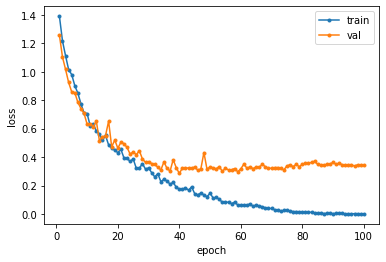

In [42]:
history.plot_train_val('loss')

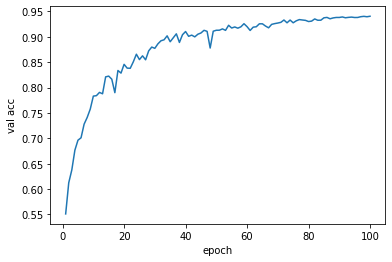

In [43]:
history.plot('val acc')